In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


In [23]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [24]:
holdout.head()
#holdout.columns

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [25]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [26]:
for df in [train,holdout]:
    #print(df.describe())
    print(df.shape)

(891, 12)
(418, 11)


In [27]:
def preprocess(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)

    for col in ["Age_categories","Fare_categories","Title","Cabin_type","Sex"]:
        df = create_dummies(df,col)
    
    return df

In [28]:
train = preprocess(train)
holdout = preprocess(holdout)

for df in [train,holdout]:
    #print(df.describe())
    print(df.columns)
    print(df.shape)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Age_categories',
       'Fare_categories', 'Title', 'Cabin_type', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male'],
      dtype='object')
(891, 43)
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Age_categories', 'Fare_categories',
       'Title', 'Cabin_ty

In [29]:
#train[["SibSp","Parch"]]
print(train["SibSp"].value_counts(dropna=False))
print(train["Parch"].value_counts(dropna=False))

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


In [30]:
print(type(train["SibSp"]))
print(type(train["Parch"]))

explore = train.copy()
explore= explore[["SibSp","Parch","Survived"]]
explore["FamilySize"] = explore[["SibSp","Parch"]].sum(axis=1)
print(explore.columns)
print(explore[explore["FamilySize"]>=5].head())


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
Index(['SibSp', 'Parch', 'Survived', 'FamilySize'], dtype='object')
    SibSp  Parch  Survived  FamilySize
13      1      5         0           6
16      4      1         0           5
25      1      5         1           6
27      3      2         0           5
50      4      1         0           5


In [31]:
%matplotlib inline

plt.figure(figsize=(10,5))
'''
plt.subplot(121)
train["SibSp"].plot.hist()
plt.subplot(122)
train["Parch"].plot.hist()
'''
'''train["SibSp"].plot.hist(alpha=0.5)
train["Parch"].plot.hist(alpha=0.5)'''






'train["SibSp"].plot.hist(alpha=0.5)\ntrain["Parch"].plot.hist(alpha=0.5)'

In [32]:
print(train["Survived"].value_counts())

0    549
1    342
Name: Survived, dtype: int64


   SibSp  Parch  Survived  FamilySize
0      1      0         0           1
1      1      0         1           1
2      0      0         1           0
3      1      0         1           1
4      0      0         0           0


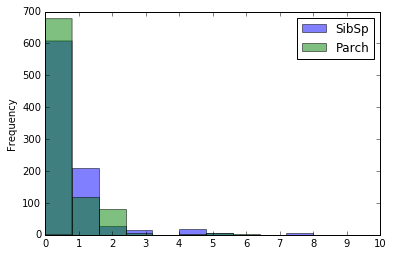

In [33]:
#use histogram to view the distribution of SibSp and Parch
print(explore.head())

explore.drop(["Survived","FamilySize"],axis=1).plot.hist(alpha=0.5)
plt.xticks(range(11))
plt.show()

   SibSp  Parch  Survived  FamilySize
0      1      0         0           1
1      1      0         1           1
2      0      0         1           0
3      1      0         1           1
4      0      0         0           0


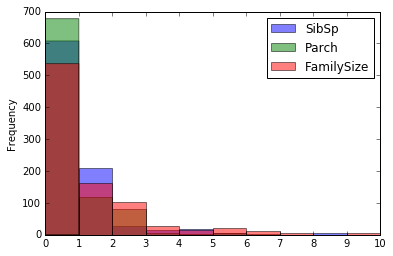

In [34]:
#use histogram to view the distribution of SibSp, Parch and FamilySize 

print(explore.head())

explore.drop(["Survived"],axis=1).plot.hist(alpha=0.5)
plt.xticks(range(11))
plt.show()

Total No SibSp 608
Who die 398
Who Survived 210
Mean (Die)= 0.654605 Mean (Survived)= 0.345395
FamilySize= 806
FamilySize 806


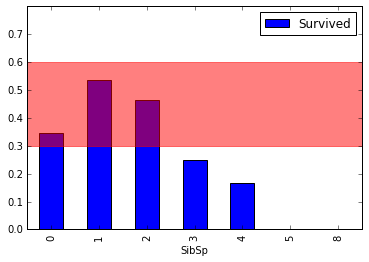

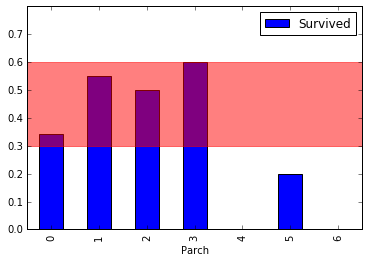

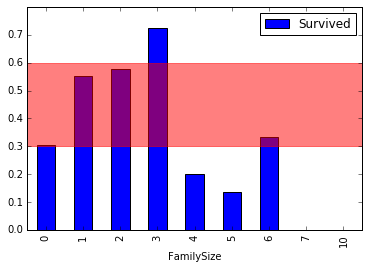

In [44]:
#use pivot tables to look at the survival rate

#train["Survived"]
#print(explore["Survived"].value_counts())
#print(explore.columns)

Num_SibSp_Die =len(explore[(explore['SibSp']==0) & (explore['Survived']==0) ])
Num_SibSp_Survived = len(explore[(explore['SibSp']==0) & (explore['Survived']==1) ])
Num_SibSp = len(explore[(explore['SibSp']==0) ])
print("Total No SibSp {}".format(Num_SibSp))
print("Who die {}".format(Num_SibSp_Die))
print("Who Survived {}".format(Num_SibSp_Survived))
SibSp_mean1 = Num_SibSp_Die/Num_SibSp
SibSp_mean2 = Num_SibSp_Survived/Num_SibSp
print("Mean (Die)=",np.round(SibSp_mean1,6),"Mean (Survived)=",np.round(SibSp_mean2,6) )



explore["FamilySize"] = explore["SibSp"] + explore["Parch"]

print("FamilySize=",explore[["SibSp","Parch"]].sum(axis=1).sum())
print("FamilySize",explore["FamilySize"].sum())
'''pivot2 = explore.pivot_table(index="SibSp",values="Survived",aggfunc=np.sum)
pivot = explore.pivot_table(index=['SibSp'],values="Survived",aggfunc=np.mean)
print("Pivot by Mean",pivot)
print("Pivot by Count",pivot2)'''

#pivot = explore.pivot_table(index=['SibSp'],values="Survived",aggfunc=np.mean)
#pivot = explore.pivot_table(index=['Pclass', 'Sex', 'Survived'], values='Age')
#pivot = explore.pivot_table(index="SibSp",values="Survived",columns="FamilySize")

#print(pivot["Survived"].sum())
#pivot.plot.bar()

'''plt.figure(figsize=(10,5))
plt.subplot(131)
pivot.plot.bar()'''

plt.figure(figsize=(10,5))

explore_col_list = ['SibSp','Parch','FamilySize']

for col in explore_col_list:
    #print(col)
    pivot = explore.pivot_table(index=[col],values="Survived",aggfunc=np.mean)
    #print(pivot)
    #plt.subplot(111)
    pivot.plot.bar(ylim=(0,0.8),yticks=np.arange(0,0.8,0.1))
    plt.axhspan(0.3,0.6,alpha=0.5,color='r')
    


In [36]:
#print(explore.describe())
print(explore[explore["FamilySize"]==0]["FamilySize"].value_counts())
print(explore[explore["FamilySize"]!=0]["FamilySize"].value_counts())
print(explore[explore["SibSp"]==0]["SibSp"].value_counts())
print(explore[explore["SibSp"]!=0]["SibSp"].value_counts())
print(explore[explore["Parch"]==0]["Parch"].value_counts())
print(explore[explore["Parch"]!=0]["Parch"].value_counts())


0    537
Name: FamilySize, dtype: int64
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamilySize, dtype: int64
0    608
Name: SibSp, dtype: int64
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
Name: Parch, dtype: int64
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


the distributions of SibSp, Parch and FamilySize are right skewed which imply mean is larger than median.

Passenger with no family member has less chance to survive. the highest chance of survived is passenger with 3 family member.

In [37]:
explore_cols=["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore["FamilySize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.pivot_table(index=["FamilySize"],values="Survived")

,Survived
FamilySize,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [38]:
def process_isalone(data):
    #df["isalone"] = (d["FamilySize"]:lamda x > 0 :1)
    '''if data["FamilySize"] == 0:
        df["isalone"] = 1
    else:
        df["isalone"] = 0
    '''
    
    data["isalone"] = np.int(0) 
    #data["isalone"] = data["isalone"].astype(int)
    data.loc[(data["FamilySize"] ==1),"isalone"] =int(0)
    data.loc[(data["FamilySize"] ==0),"isalone"] =int(1)
    return data

In [39]:

#train = pd.read_csv("train.csv")
#holdout = pd.read_csv("test.csv")

train["FamilySize"] = train[["SibSp","Parch"]].sum(axis=1)
train = process_isalone(train)
train.columns
print(train[["FamilySize","isalone"]].head())

holdout["FamilySize"] = holdout[["SibSp","Parch"]].sum(axis=1)
holdout = process_isalone(holdout)
holdout.columns
print(holdout[["FamilySize","isalone"]].head())




   FamilySize  isalone
0           1        0
1           1        0
2           0        1
3           1        0
4           0        1
   FamilySize  isalone
0           0        1
1           1        0
2           0        1
3           0        1
4           2        0


In [40]:

def select_features(df):
    df = df.dropna(axis=1)
    df = df.select_dtypes(np.number)
    #df = df.select_dtypes(np.dtype(int).type)
    
    all_X = df.drop(["PassengerId","Survived"],axis=1)
    all_Y = df["Survived"]

    #train._get_numeric_data()
    #train["Age"].fillna(values=0)
    #train.select_dtypes(np.number)
    rs = RandomForestClassifier(random_state=1)
    selector = RFECV(rs,cv=10)
    selector = selector.fit(all_X,all_Y)
    print(type(all_X.columns[selector.support_]))
    best_col = list(all_X.columns[selector.support_])

    #print("best columns"+"\n",best_col)
    
    return best_col
    
best_col_train = select_features(train)

#['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


<class 'pandas.core.indexes.base.Index'>


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



In [41]:
def select_model(df, features):
    all_X = df[features]
    all_Y = df["Survived"]
    lr = LogisticRegression()
    knn = KNeighborsClassifier()
    rf = RandomForestClassifier()
    
    model_dict = [
                    {
                        "name":"LogisticRegression",
                        "estimator":lr,
                        "hyperparameters":
                             {
                                 "solver":["newton-cg","lbfgs","liblinear"]
                             }
                     },
                    {
                        "name":"KNeighborsClassifier",
                        "estimator":knn,
                        "hyperparameters":
                            {
                                "n_neighbors": range(1,20,2),
                                "weights":["distance","uniform"],
                                "algorithm":["ball_tree","kd_tree","brute"],
                                "p":[1,2]
                            }
                    },
                    {
                        "name":"RandomForestClassifier",
                        "estimator":rf,
                        "hyperparameters":
                            {
                                "n_estimators":[4,6,9],
                                "criterion":["entropy","gini"],
                                "max_depth":[2,5,10],
                                "max_features":["log2","sqrt"],
                                "min_samples_leaf":[1,5,8],
                                "min_samples_split":[2,3,5]
                            }
                        
                    }
                ]
    
    for model in model_dict:
        print(model["name"])
        #print(model["hyperparameters"])
        grid = GridSearchCV(estimator = model["estimator"],param_grid=model["hyperparameters"],cv=10)
        grid.fit(all_X,all_Y)
        
        model["best_score"] = grid.best_score_
        model["best_para"] = grid.best_params_
        model["best_estimator"] = grid.best_estimator_

        print("Best score {}".format(model["best_score"]))
        print("Best param {}".format(model["best_para"]))

    return model_dict    
        
best_features = select_features(train)        
best_model = select_model(train,best_features)    




/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



<class 'pandas.core.indexes.base.Index'>
LogisticRegression
Best score 0.8181818181818182
Best param {'solver': 'newton-cg'}
KNeighborsClassifier
Best score 0.7800224466891134
Best param {'n_neighbors': 3, 'p': 1, 'algorithm': 'kd_tree', 'weights': 'uniform'}
RandomForestClassifier
Best score 0.8383838383838383
Best param {'max_depth': 10, 'n_estimators': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'min_samples_split': 3, 'criterion': 'gini'}


In [42]:
def save_submission_file(model,features,filename="submission.csv"):    
    predictions = model.predict(holdout[features])
    submission_dict = {"PassengerId": holdout["PassengerId"],
             "Survived":predictions}
    submission = pd.DataFrame(submission_dict)
    #print(submission)
    
    #print(type(pd.DataFrame(submission_dict["PassengerId"])))
    #submission = pd.concat([pd.DataFrame(submission_dict["PassengerId"]),pd.DataFrame(submission_dict["Survived"]) ],axis=1)
    #print(submission.columns)
    submission.to_csv(filename,index=False)
    
rf = best_model[2]["best_estimator"]    
print("best model name = {}".format(best_model[2]["name"]))
print("best estimator = {}".format(rf))
   
save_submission_file(best_model[2]["best_estimator"],best_features)    

#save_submission_file(best_model,best_features) 
#for key,val in best_model.items():
#    print(key,value)


best model name = RandomForestClassifier
best estimator = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
